<a href="https://colab.research.google.com/github/AmrElsayyad/Head-Pose-Estimation/blob/main/Head_Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

### Required Libraries

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd
import scipy.io as sio
import warnings

from google.colab.patches import cv2_imshow
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.multioutput import RegressorChain
from sklearn.svm import SVR

warnings.filterwarnings("ignore")

### Downloading Data

In [3]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [4]:
# Downloading AFLW2000 Data

%%capture
if not os.path.isdir('./AFLW2000-3D'):

    if not os.path.isfile('./AFLW2000-3D.zip'):
        !gdown 1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap

    !jar xf ./AFLW2000-3D.zip

### Getting Images

In [5]:
# Getting all images
files = [
    os.path.join(dirname, filename)
    for dirname, _, filenames in os.walk("./AFLW2000/")
    for filename in filenames
    if filename.endswith(".jpg")
]

# Choosing random image
random_file = np.random.choice(files, 1)[0]

### Show Face Landmarks

In [6]:
def get_face_landmarks(image):
    """Get face landmarks for a given image"""

    landmarks = np.empty([468, 3])
    faceModule = mp.solutions.face_mesh

    # loading image and its corresponding mat file
    with faceModule.FaceMesh(static_image_mode=True) as faces:

        # processing the face to extract the landmark points (468 point) for each x, y and z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.multi_face_landmarks != None:
            landmarks = np.array(
                [
                    [landmark.x, landmark.y, landmark.z]
                    for landmark in results.multi_face_landmarks[0].landmark
                ]
            )

    return landmarks

In [7]:
def draw_face_landmarks(image):
    """Draw face landmarks for a given image"""

    image = image.copy()

    # Get landmarks
    landmarks = get_face_landmarks(image)

    # Looping over landmarks
    if landmarks is not None:
        for landmark in landmarks:
            # note: the x and y values are scaled to the their width and height
            # so we will get back their actual value in the image
            shape = image.shape
            relative_x = int(landmark[0] * shape[1])
            relative_y = int(landmark[1] * shape[0])

            cv2.circle(
                image,
                (relative_x, relative_y),
                radius=1,
                color=(0, 255, 0),
                thickness=1,
            )
    
    return image


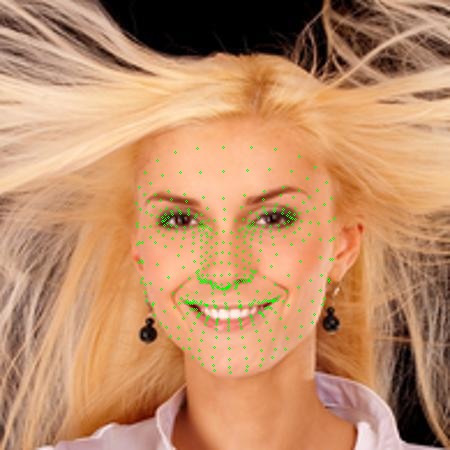

In [8]:
image = cv2.imread(random_file)

cv2_imshow(draw_face_landmarks(image))

### Drawing Axes

In [9]:
def get_pose_para(mat_filepath):
    # loading the mat file to extract the 3 angels of the face (pitch, yaw, roll)
    mat_file = sio.loadmat(mat_filepath)

    # extracting the labels 3 angles
    pose_para = mat_file["Pose_Para"][0][:3]

    return np.array([pose_para[0], pose_para[1], pose_para[2]])

In [10]:
def draw_axis(image, pitch, yaw, roll, tdx=None, tdy=None, size=100):
    image = image.copy()

    yaw = -yaw
    if tdx == None or tdy == None:
        height, width = image.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing right drawn in red
    x1 = size * (np.cos(yaw) * np.cos(roll)) + tdx
    y1 = size * (np.cos(pitch) * np.sin(roll) + np.cos(roll) * np.sin(pitch) * np.sin(yaw)) + tdy

    # Y-Axis pointing down drawn in green
    x2 = size * (-np.cos(yaw) * np.sin(roll)) + tdx
    y2 = size * (np.cos(pitch) * np.cos(roll) - np.sin(pitch) * np.sin(yaw) * np.sin(roll)) + tdy

    # Z-Axis pointing out drawn in blue
    x3 = size * (np.sin(yaw)) + tdx
    y3 = size * (-np.cos(yaw) * np.sin(pitch)) + tdy

    cv2.line(image, (int(tdx), int(tdy)), (int(x1), int(y1)), (0, 0, 255), 2)
    cv2.line(image, (int(tdx), int(tdy)), (int(x2), int(y2)), (0, 255, 0), 2)
    cv2.line(image, (int(tdx), int(tdy)), (int(x3), int(y3)), (255, 0, 0), 2)

    return image

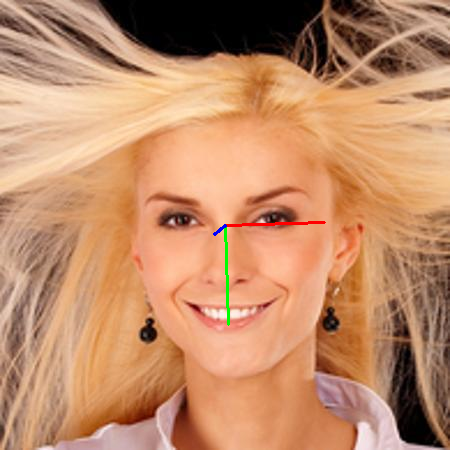

In [11]:
pitch, yaw, roll = get_pose_para(random_file.replace(".jpg", ".mat"))

cv2_imshow(draw_axis(image, pitch, yaw, roll))

### Creating Training Dataset

In [12]:
def get_features(image):
    """Return image features for x, y coordinates"""

    # Get landmarks for all images
    landmarks = get_face_landmarks(image)

    # Get x, y for all of the landmarks
    features_x = pd.Series(
        landmarks[:, 0],
        index=[f"x_{i}" for i in range(468)]
    )

    features_y = pd.Series(
        landmarks[:, 1],
        index=[f"y_{i}" for i in range(468)]
    )

    return pd.concat([features_x, features_y])

In [13]:
def create_dataset(images_path, save=True, save_path="./"):
    """Create DataFrame for images found in images_path"""

    # Check for path
    if os.path.isdir(images_path):
        # Getting list of files
        files = sorted(
            [
                os.path.join(dirname, filename)
                for dirname, _, filenames in os.walk(images_path)
                for filename in filenames
                if filename.endswith(".jpg")
            ]
        )

        # Creating index using filepaths
        index = pd.Index(files, name="filepath")

        # Getting features for all images
        features = pd.concat(
            [get_features(cv2.imread(file)) for file in files], axis=1
        ).T

        # Setting features index to filepaths
        features.index = index

        # Getting target's pitch, yaw and roll
        target = pd.DataFrame(
            [get_pose_para(file.replace(".jpg", ".mat")) for file in files],
            index=index,
            columns=["pitch", "yaw", "roll"]
        )

        # Creating dataframe
        data = pd.concat([features, target], axis=1)

        # Drop NAs
        data = data.dropna()

        # Save data
        if save:
            data.to_parquet(save_path + "data.parquet")

        return data
    else:
        print(f"{images_path} was not found!")


In [14]:
if os.path.isfile("./data.parquet"):
    data = pd.read_parquet("data.parquet")
else:
    data = create_dataset("./AFLW2000/")

In [15]:
data.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_461,y_462,y_463,y_464,y_465,y_466,y_467,pitch,yaw,roll
filepath,,,,,,,,,,,,,,,,,,,,,
./AFLW2000/image00002.jpg,4.856505e-01,0.489194,0.489802,0.479730,0.490558,0.493633,0.503193,0.363678,0.508629,0.510569,...,0.644283,0.644457,0.485137,0.492813,0.500371,0.471336,0.464005,-0.399231,0.018227,0.085676
./AFLW2000/image00004.jpg,4.415017e-01,0.417273,0.448839,0.435994,0.415757,0.426780,0.464200,0.464412,0.474128,0.472069,...,0.600357,0.604871,0.506956,0.511724,0.514913,0.500244,0.495387,0.470065,1.189533,0.300959
./AFLW2000/image00006.jpg,3.177972e-01,0.321328,0.318316,0.311064,0.321459,0.320353,0.316353,0.247193,0.314674,0.314501,...,0.778855,0.779742,0.717794,0.720868,0.723342,0.713071,0.709798,-0.184650,0.881137,-0.236852
./AFLW2000/image00008.jpg,5.039217e-01,0.469521,0.489504,0.444433,0.461756,0.457114,0.451360,0.361577,0.437648,0.428051,...,0.651913,0.652300,0.500958,0.510606,0.518652,0.455611,0.444623,-0.175379,0.299208,-0.373374
./AFLW2000/image00010.jpg,8.436978e-316,0.469521,0.489504,0.444433,0.461756,0.457114,0.451360,0.361577,0.437648,0.428051,...,0.651913,0.652300,0.500958,0.510606,0.518652,0.455611,0.444623,-0.882169,1.198004,-1.033374


In [16]:
data.describe()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_461,y_462,y_463,y_464,y_465,y_466,y_467,pitch,yaw,roll
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,4.679160e-01,0.503081,0.504076,0.489836,0.502800,0.502777,0.503181,0.391571,0.502861,0.502522,...,0.617781,0.621091,0.497862,0.503318,0.507507,0.485795,0.478292,-0.107145,0.014077,-0.034479
std,1.376775e-01,0.054114,0.038377,0.044904,0.055634,0.051452,0.040804,0.046469,0.045209,0.050532,...,0.027317,0.025844,0.024247,0.022894,0.022335,0.038599,0.040812,0.628119,0.654185,0.716014
min,4.088669e-316,0.227159,0.249772,0.222207,0.223030,0.224847,0.235638,0.194867,0.234697,0.229952,...,0.147400,0.148695,0.049809,0.055864,0.060640,0.032022,0.024076,-12.457202,-6.130066,-16.969362
25%,4.742109e-01,0.468328,0.481075,0.459717,0.465573,0.467805,0.477736,0.360476,0.477651,0.474533,...,0.605412,0.609776,0.484791,0.491389,0.496259,0.463172,0.454534,-0.258503,-0.294246,-0.174806
50%,5.028678e-01,0.501015,0.503073,0.485290,0.501021,0.500781,0.501353,0.383725,0.501551,0.501630,...,0.620639,0.623347,0.496832,0.502140,0.506312,0.485539,0.477900,-0.122268,0.019702,-0.018098
75%,5.240908e-01,0.537576,0.525719,0.516269,0.538625,0.535108,0.529188,0.418415,0.527570,0.530254,...,0.634074,0.636259,0.509472,0.514127,0.518074,0.506889,0.500368,0.040192,0.334715,0.134378
max,9.284914e-01,0.929157,0.923774,0.901552,0.926027,0.918533,0.896907,0.802042,0.883313,0.878124,...,0.778855,0.779742,0.719222,0.720868,0.723342,0.741343,0.750775,15.598820,3.277500,5.829394


### Train Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(["pitch", "yaw", "roll"], axis=1),
    data[["pitch", "yaw", "roll"]],
    random_state=1,
)

### Scaling

In [18]:
def std_scaler(X):
    """Perform row-wise (per image) standardization for x, y coordinates separately"""

    x_mean = X.loc[:, "x_0" : "x_467"].mean(axis=1)
    x_std = X.loc[:, "x_0" : "x_467"].std(axis=1) + 1e-8 # to avoid division by 0

    y_mean = X.loc[:, "y_0" : "y_467"].mean(axis=1)
    y_std = X.loc[:, "y_0" : "y_467"].std(axis=1) + 1e-8 # to avoid division by 0

    return pd.concat(
        [
            X.loc[:, "x_0" : "x_467"].apply(lambda x: (x - x_mean) / x_std),
            X.loc[:, "y_0" : "y_467"].apply(lambda y: (y - y_mean) / y_std)
        ], axis=1
    )

In [19]:
X_train_scaled = std_scaler(X_train)
X_test_scaled = std_scaler(X_test)

### Base Model

In [20]:
model = RegressorChain(SVR(), random_state=1).fit(X_train_scaled, y_train)

pred_train = model.predict(X_train_scaled)
pred_test = model.predict(X_test_scaled)

metrics.mean_squared_error(y_test, pred_test)

0.11035270699042866

### Validating Model Predictions

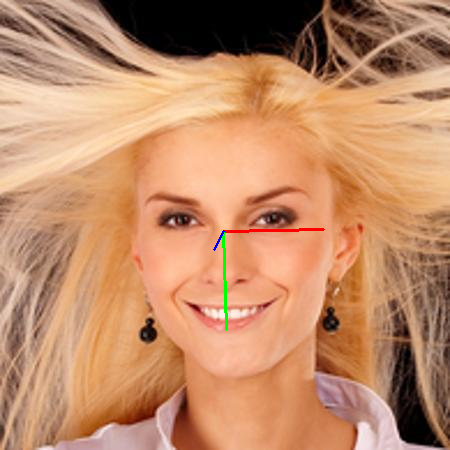

In [21]:
try:
    index = np.where(X_test_scaled.index == random_file)[0][0]
    features = pd.DataFrame(X_test_scaled.iloc[index]).T
except:
    index = np.where(X_train_scaled.index == random_file)[0][0]
    features = pd.DataFrame(X_train_scaled.iloc[index]).T

pitch, yaw, roll = model.predict(features)[0]

tdx = get_features(image)["x_6"] * image.shape[1]
tdy = get_features(image)["y_6"] * image.shape[0]

cv2_imshow(draw_axis(image, pitch, yaw, roll, tdx, tdy))

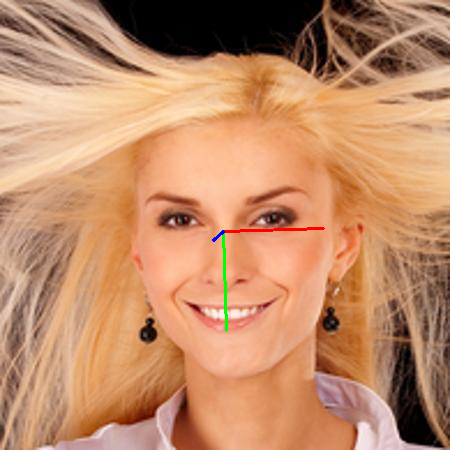

In [22]:
pitch, yaw, roll = get_pose_para(random_file.replace(".jpg", ".mat"))

cv2_imshow(draw_axis(image, pitch, yaw, roll, tdx, tdy))

Good enough! there's only a slight difference.

### Training Model

In [23]:
X = data.drop(["pitch", "yaw", "roll"], axis=1)
y = data[["pitch", "yaw", "roll"]]

model = RegressorChain(SVR(), random_state=1).fit(std_scaler(X), y)

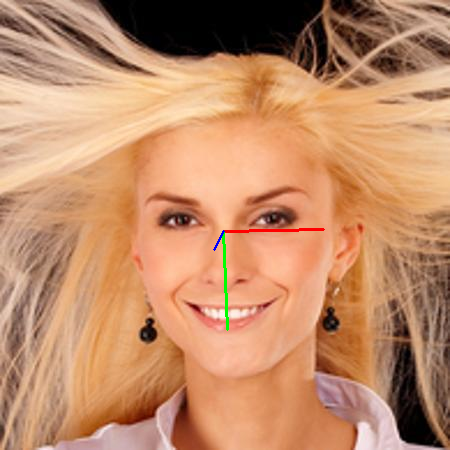

In [24]:
pitch, yaw, roll = model.predict(features)[0]

tdx = get_features(image)["x_6"] * image.shape[1]
tdy = get_features(image)["y_6"] * image.shape[0]

cv2_imshow(draw_axis(image, pitch, yaw, roll, tdx, tdy))

### Downloading Video

In [25]:
%%capture
if not os.path.isfile("./SMOKIN'! - The Mask.mp4"):
    !gdown 1u9Ip4ieGl6B-eeZYykOIrD0kWlmAis8c

### Drawing Axes for Each Frame

In [26]:
cap = cv2.VideoCapture("./SMOKIN'! - The Mask.mp4")
frames = []

while (cap.isOpened()):
    ret, frame = cap.read()

    if not ret:
        break
    
    features = pd.DataFrame(get_features(frame)).T

    if not features.empty:
        try:
            pitch, yaw, roll = model.predict(std_scaler(features))[0]

            tdx = features["x_6"][0] * frame.shape[1]
            tdy = features["y_6"][0] * frame.shape[0]

            if (tdx > 1) & (tdy > 1):
                frame = draw_axis(frame, pitch, yaw, roll, tdx, tdy)
        except:
            pass
    
    frames.append(frame)


### Saving Video

In [27]:
writer = cv2.VideoWriter(
    "smokin-the-mask.mp4", cv2.VideoWriter_fourcc(*"mp4v"), 24, frames[0].shape[-2::-1]
)

for frame in frames:
    writer.write(frame)

writer.release()